<a href="https://colab.research.google.com/github/outfox330/ML_Models_on_Time_Series/blob/main/BTC_FORECAST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install ray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 MB 8.3 MB/s eta 0:00:00


In [ ]:
pip install skfolio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.7/718.7 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 72.0 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.15.0
    Uninstalling plotly-5.15.0:
      Successfully uninstalled plotly-5.15.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [ ]:
pip install neuralforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.4/249.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 1.5 MB/s eta 0:00:00


In [ ]:
! pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 11.0 MB/s eta 0:00:00


In [ ]:
pip install factor_analyzer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 2.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for factor_analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42565 sha256=86c9185cd9338dab78a4d6de53d32b6f059c93e07219adf2ec9b6bc61112bcb4
  Stored in directory: /root/.cache/pip/wheels/24/59/82/6493618e30ed1cb7a013b9e1b0c9e17de80b04dfcef4ba8a4d
Successfully built factor_analyzer


In [ ]:
pip install yfinance

In [ ]:
import pandas as pd
import numpy as np

from ray import tune

In [ ]:
from neuralforecast.auto import NHITS, BiTCN
from neuralforecast.core import NeuralForecast

import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM, NHITS, RNN, NBEATS, PatchTST
from neuralforecast.models import TSMixer, iTransformer, TimesNet
from neuralforecast.auto import MLP, AutoMLP



In [ ]:
df = pd.read_csv('btc_price.csv')
df.head()

,open,high,low,close,date,daily_change
0,"64,342.23","64,489.71","62,849.56","62,880.66",8/26/24,-0.022583
1,64176.37,64996.42,63833.52,64333.54,8/25/24,0.002408
2,64103.87,64513.79,63619.92,64178.99,8/24/24,0.001321
3,60380.95,64947.06,60372.05,64094.36,8/23/24,0.061483
4,61168.32,61408.11,59815.25,60381.91,8/22/24,-0.012967


In [ ]:
df_change = df[['date','daily_change']]
df_change.columns = ['ds','y']
df_change['unique_id'] = 'test'
df_change['ds'] = pd.to_datetime(df_change['ds'])
df_change

<ipython-input-7-cb823e1729fc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_change['unique_id'] = 'test'
<ipython-input-7-cb823e1729fc>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_change['ds'] = pd.to_datetime(df_change['ds'])
<ipython-input-7-cb823e1729fc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_change['ds'] = pd.to_datetime(df_change['ds'])


,ds,y,unique_id
0,2024-08-26,-0.022583,test
1,2024-08-25,0.002408,test
2,2024-08-24,0.001321,test
3,2024-08-23,0.061483,test
4,2024-08-22,-0.012967,test
...,...,...,...
1373,2020-11-22,-0.014603,test
1374,2020-11-21,0.001123,test
1375,2020-11-20,0.045138,test
1376,2020-11-19,0.000735,test


In [ ]:
df_change = df_change.dropna(axis=0)
df_change

,ds,y,unique_id
0,2024-08-26,-0.022583,test
1,2024-08-25,0.002408,test
2,2024-08-24,0.001321,test
3,2024-08-23,0.061483,test
4,2024-08-22,-0.012967,test
...,...,...,...
1372,2020-11-23,-0.000320,test
1373,2020-11-22,-0.014603,test
1374,2020-11-21,0.001123,test
1375,2020-11-20,0.045138,test


In [ ]:
horizon =2
models = [NBEATS(input_size=15,h=horizon, max_steps=200, enable_checkpointing=True),
         NHITS(input_size=15,h=horizon, max_steps=200, enable_checkpointing=True),
          AutoMLP(config=dict(max_steps=200,
                              input_size=tune.choice([24]),
                              learning_rate=tune.choice([1e-3])),
                  h=horizon, num_samples=1),
          TSMixer(h=horizon, input_size=15, n_series=1, max_steps=200),
          iTransformer(h=horizon, input_size=15, n_series=1, max_steps=200),
          PatchTST(h=horizon, input_size=15, max_steps=200),
          TimesNet(h=horizon, input_size=15, max_steps=200)]

nf = NeuralForecast(models=models, freq='D')
nf.fit(df=df_change)
Y_hat_df = nf.predict().reset_index()
Y_hat_df

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-08-27 00:39:29,372	INFO worker.py:1781 -- Started a local Ray instance.
2024-08-27 00:39:31,700	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.


+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2024-08-27_00-39-26   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 1                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2024-08-27_00-39-26
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-08-27_00-39-26_237659_1092/artifacts/2024-08-27_00-39-31/_train_tune_2024-08-27_00-39-26/driver_artifacts`


(_train_tune pid=2373) /usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
(_train_tune pid=2373)   return torch.load(i

Epoch 99:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.021, train_loss_epoch=0.021]


/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  8.12it/s, v_num=0, train_loss_step=0.0215, train_loss_epoch=0.021]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 197:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0181, train_loss_epoch=0.0181, valid_loss=0.0212]


2024-08-27 00:40:19,041	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/_train_tune_2024-08-27_00-39-26' in 0.0065s.


Epoch 199:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0191, train_loss_epoch=0.0191, valid_loss=0.0212]


(_train_tune pid=2373) `Trainer.fit` stopped: `max_steps=200` reached.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  8.06it/s, v_num=0, train_loss_step=0.0173, train_loss_epoch=0.0191, valid_loss=0.0212]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  7.00it/s, v_num=0, train_loss_step=0.0173, train_loss_epoch=0.0173, valid_loss=0.0291]



Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,unique_id,ds,NBEATS,NHITS,AutoMLP,TSMixer,iTransformer,PatchTST,TimesNet
0,test,2024-08-27,0.002391,0.001820,0.000675,-0.000256,0.004279,0.007691,0.001042
1,test,2024-08-28,0.000108,-0.000811,-0.001025,0.003949,0.003125,0.004376,0.001623


In [ ]:
Y_hat_df.to_csv('daily_change_output.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

# New Section

In [ ]:
df1 = pd.read_csv('bitcoin.csv')
df1.head()

,close,date
0,62880.65865,8/26/24
1,64333.54418,8/25/24
2,64178.99065,8/24/24
3,64094.35721,8/23/24
4,60381.91246,8/22/24


In [ ]:
df2 = pd.read_csv('bnb.csv')
df2.head()

,close,date
0,548.828031,8/26/24
1,574.249965,8/25/24
2,580.762177,8/24/24
3,591.806050,8/23/24
4,583.051855,8/22/24


In [ ]:
df3 = pd.read_csv('dogecoin.csv')
df3.head()

,close,date
0,0.105292,8/26/24
1,0.109698,8/25/24
2,0.112631,8/24/24
3,0.112927,8/23/24
4,0.105308,8/22/24


In [ ]:
df4 = pd.read_csv('eth.csv')
df4.head()

,close,date
0,2681.340514,8/26/24
1,2749.157667,8/25/24
2,2769.389732,8/24/24
3,2764.447103,8/23/24
4,2622.951355,8/22/24


In [ ]:
df5 = pd.read_csv('solana.csv')
df5.head()

,close,date
0,157.236879,8/26/24
1,158.909125,8/25/24
2,160.731744,8/24/24
3,153.107085,8/23/24
4,143.257930,8/22/24


In [ ]:
df6 = pd.read_csv('shiba.csv')
df6.head()

,close,date
0,0.000015,8/26/24
1,0.000015,8/25/24
2,0.000016,8/24/24
3,0.000015,8/23/24
4,0.000014,8/22/24


In [ ]:
df_total = df1
df_total = df_total[['date','close']]
df_total.columns = ['date','bitcoin']
df_total

,date,bitcoin
0,8/26/24,62880.65865
1,8/25/24,64333.54418
2,8/24/24,64178.99065
3,8/23/24,64094.35721
4,8/22/24,60381.91246
...,...,...
951,1/18/22,42375.63284
952,1/17/22,42250.54937
953,1/16/22,43113.88011
954,1/15/22,43177.39679


In [ ]:
df_total['bnb'] = df2['close']
df_total['dogecoin'] = df3['close']
df_total['eth'] = df4['close']
df_total['solana'] = df5['close']
df_total['shiba'] = df6['close']
df_total

<ipython-input-35-1ab4c03d3e5b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total['bnb'] = df2['close']
<ipython-input-35-1ab4c03d3e5b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total['dogecoin'] = df3['close']
<ipython-input-35-1ab4c03d3e5b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

,date,bitcoin,bnb,dogecoin,eth,solana,shiba
0,8/26/24,62880.65865,548.828031,0.105292,2681.340514,157.236879,0.000015
1,8/25/24,64333.54418,574.249965,0.109698,2749.157667,158.909125,0.000015
2,8/24/24,64178.99065,580.762177,0.112631,2769.389732,160.731744,0.000016
3,8/23/24,64094.35721,591.806050,0.112927,2764.447103,153.107085,0.000015
4,8/22/24,60381.91246,583.051855,0.105308,2622.951355,143.257930,0.000014
...,...,...,...,...,...,...,...
951,1/18/22,42375.63284,472.005051,0.165485,3164.025254,141.587192,0.000028
952,1/17/22,42250.54937,475.709867,0.171145,3212.304897,139.926008,0.000029
953,1/16/22,43113.88011,498.427925,0.177176,3350.921969,147.856514,0.000030
954,1/15/22,43177.39679,494.988068,0.185103,3330.530846,147.801178,0.000031


In [ ]:
df_total['date'] = pd.to_datetime(df_total['date'])

<ipython-input-36-8e756b067241>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_total['date'] = pd.to_datetime(df_total['date'])
<ipython-input-36-8e756b067241>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total['date'] = pd.to_datetime(df_total['date'])


In [ ]:
df_total = df_total.sort_values('date')
df_total

,date,bitcoin,bnb,dogecoin,eth,solana,shiba
955,2022-01-14,43099.69983,489.867424,0.183549,3310.001423,146.159033,0.000031
954,2022-01-15,43177.39679,494.988068,0.185103,3330.530846,147.801178,0.000031
953,2022-01-16,43113.88011,498.427925,0.177176,3350.921969,147.856514,0.000030
952,2022-01-17,42250.54937,475.709867,0.171145,3212.304897,139.926008,0.000029
951,2022-01-18,42375.63284,472.005051,0.165485,3164.025254,141.587192,0.000028
...,...,...,...,...,...,...,...
4,2024-08-22,60381.91246,583.051855,0.105308,2622.951355,143.257930,0.000014
3,2024-08-23,64094.35721,591.806050,0.112927,2764.447103,153.107085,0.000015
2,2024-08-24,64178.99065,580.762177,0.112631,2769.389732,160.731744,0.000016
1,2024-08-25,64333.54418,574.249965,0.109698,2749.157667,158.909125,0.000015


In [ ]:
eur = pd.read_csv('EURUSD.csv')
eur.columns = ['date','eur_usd']
eur['date'] = pd.to_datetime(eur['date'])
eur.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684 entries, 0 to 683
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     684 non-null    datetime64[ns]
 1   eur_usd  684 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 10.8 KB


<ipython-input-38-a44862e86a7c>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  eur['date'] = pd.to_datetime(eur['date'])


In [ ]:
jpy = pd.read_csv('USDJPY.csv')
jpy.columns = ['date','usd_jpy']
jpy['date'] = pd.to_datetime(jpy['date'])
jpy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683 entries, 0 to 682
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     683 non-null    datetime64[ns]
 1   usd_jpy  683 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 10.8 KB


<ipython-input-39-0c1ba8773bb9>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  jpy['date'] = pd.to_datetime(jpy['date'])


In [ ]:
df_total = pd.merge(df_total, eur, on = 'date', how='left')
df_total = pd.merge(df_total, jpy, on = 'date', how='left')
df_total



,date,bitcoin,bnb,dogecoin,eth,solana,shiba,eur_usd,usd_jpy
0,2022-01-14,43099.69983,489.867424,0.183549,3310.001423,146.159033,0.000031,1.145712,114.117996
1,2022-01-15,43177.39679,494.988068,0.185103,3330.530846,147.801178,0.000031,NaN,NaN
2,2022-01-16,43113.88011,498.427925,0.177176,3350.921969,147.856514,0.000030,NaN,NaN
3,2022-01-17,42250.54937,475.709867,0.171145,3212.304897,139.926008,0.000029,1.141070,114.306000
4,2022-01-18,42375.63284,472.005051,0.165485,3164.025254,141.587192,0.000028,1.141057,114.570999
...,...,...,...,...,...,...,...,...,...
951,2024-08-22,60381.91246,583.051855,0.105308,2622.951355,143.257930,0.000014,1.115536,145.117996
952,2024-08-23,64094.35721,591.806050,0.112927,2764.447103,153.107085,0.000015,1.111716,146.201996
953,2024-08-24,64178.99065,580.762177,0.112631,2769.389732,160.731744,0.000016,NaN,NaN
954,2024-08-25,64333.54418,574.249965,0.109698,2749.157667,158.909125,0.000015,NaN,NaN


In [ ]:
df_total['dayofweek'] = df_total['date'].dt.dayofweek
df_total

,date,bitcoin,bnb,dogecoin,eth,solana,shiba,eur_usd,usd_jpy,dayofweek
0,2022-01-14,43099.69983,489.867424,0.183549,3310.001423,146.159033,0.000031,1.145712,114.117996,4
1,2022-01-15,43177.39679,494.988068,0.185103,3330.530846,147.801178,0.000031,NaN,NaN,5
2,2022-01-16,43113.88011,498.427925,0.177176,3350.921969,147.856514,0.000030,NaN,NaN,6
3,2022-01-17,42250.54937,475.709867,0.171145,3212.304897,139.926008,0.000029,1.141070,114.306000,0
4,2022-01-18,42375.63284,472.005051,0.165485,3164.025254,141.587192,0.000028,1.141057,114.570999,1
...,...,...,...,...,...,...,...,...,...,...
951,2024-08-22,60381.91246,583.051855,0.105308,2622.951355,143.257930,0.000014,1.115536,145.117996,3
952,2024-08-23,64094.35721,591.806050,0.112927,2764.447103,153.107085,0.000015,1.111716,146.201996,4
953,2024-08-24,64178.99065,580.762177,0.112631,2769.389732,160.731744,0.000016,NaN,NaN,5
954,2024-08-25,64333.54418,574.249965,0.109698,2749.157667,158.909125,0.000015,NaN,NaN,6


In [ ]:
df_total = df_total.loc[df_total.dayofweek==4]
df_total

,date,bitcoin,bnb,dogecoin,eth,solana,shiba,eur_usd,usd_jpy,dayofweek
0,2022-01-14,43099.69983,489.867424,0.183549,3310.001423,146.159033,0.000031,1.145712,114.117996,4
7,2022-01-21,36457.31810,383.073926,0.142640,2557.931623,111.966060,0.000022,1.131375,113.992996,4
14,2022-01-28,37784.33326,386.084392,0.141656,2547.091978,91.312893,0.000021,1.114703,115.351997,4
21,2022-02-04,41500.87538,399.029607,0.147503,2983.586995,112.174249,0.000022,1.143576,114.957001,4
28,2022-02-11,42407.93794,400.422400,0.144847,2927.383633,96.381880,0.000029,1.141553,116.046997,4
...,...,...,...,...,...,...,...,...,...,...
924,2024-07-26,67912.06310,581.077923,0.134318,3275.951424,183.136714,0.000017,1.085128,153.697006,4
931,2024-08-02,61415.06457,542.915190,0.111508,2986.013153,152.638227,0.000015,1.078760,149.201004,4
938,2024-08-09,60880.11220,509.182707,0.103974,2599.598584,156.457221,0.000014,1.091572,147.669006,4
945,2024-08-16,58894.10416,519.968635,0.100439,2593.186443,139.330564,0.000013,1.097273,149.222000,4


In [ ]:
import yfinance as yf
yf_data = yf.download("SPY AAPL MSFT AMD CSCO", start="2022-01-14", end="2024-08-26")['Close']
yf_data = yf_data.reset_index()
yf_data.columns = ['date','aapl','amd','csco','msft','spy']
yf_data['date'] = pd.to_datetime(yf_data['date'])
yf_data = yf_data.sort_values('date')
yf_data['dayofweek'] = yf_data['date'].dt.dayofweek
yf_data = yf_data.loc[yf_data.dayofweek==4]
yf_data['date'] = yf_data['date'].dt.tz_convert(None)
yf_data

[*********************100%***********************]  5 of 5 completed


,date,aapl,amd,csco,msft,spy,dayofweek
0,2022-01-14,173.070007,136.880005,61.360001,310.200012,464.720001,4
4,2022-01-21,162.410004,118.809998,56.680000,296.029999,437.980011,4
9,2022-01-28,170.330002,105.239998,55.610001,308.260010,441.950012,4
14,2022-02-04,172.389999,123.599998,55.150002,305.940002,448.700012,4
19,2022-02-11,168.639999,113.180000,53.900002,295.040009,440.459991,4
...,...,...,...,...,...,...,...
634,2024-07-26,217.960007,139.990005,47.880001,425.269989,544.440002,4
639,2024-08-02,219.860001,132.500000,46.660000,408.489990,532.900024,4
644,2024-08-09,216.240005,134.270004,45.470001,406.019989,532.989990,4
649,2024-08-16,226.050003,148.559998,49.459999,418.470001,554.309998,4


In [ ]:
df_total = pd.merge(df_total, yf_data, on = 'date', how='left')
df_total

,date,bitcoin,bnb,dogecoin,eth,solana,shiba,eur_usd,usd_jpy,dayofweek_x,aapl,amd,csco,msft,spy,dayofweek_y
0,2022-01-14,43099.69983,489.867424,0.183549,3310.001423,146.159033,0.000031,1.145712,114.117996,4,173.070007,136.880005,61.360001,310.200012,464.720001,4.0
1,2022-01-21,36457.31810,383.073926,0.142640,2557.931623,111.966060,0.000022,1.131375,113.992996,4,162.410004,118.809998,56.680000,296.029999,437.980011,4.0
2,2022-01-28,37784.33326,386.084392,0.141656,2547.091978,91.312893,0.000021,1.114703,115.351997,4,170.330002,105.239998,55.610001,308.260010,441.950012,4.0
3,2022-02-04,41500.87538,399.029607,0.147503,2983.586995,112.174249,0.000022,1.143576,114.957001,4,172.389999,123.599998,55.150002,305.940002,448.700012,4.0
4,2022-02-11,42407.93794,400.422400,0.144847,2927.383633,96.381880,0.000029,1.141553,116.046997,4,168.639999,113.180000,53.900002,295.040009,440.459991,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,2024-07-26,67912.06310,581.077923,0.134318,3275.951424,183.136714,0.000017,1.085128,153.697006,4,217.960007,139.990005,47.880001,425.269989,544.440002,4.0
133,2024-08-02,61415.06457,542.915190,0.111508,2986.013153,152.638227,0.000015,1.078760,149.201004,4,219.860001,132.500000,46.660000,408.489990,532.900024,4.0
134,2024-08-09,60880.11220,509.182707,0.103974,2599.598584,156.457221,0.000014,1.091572,147.669006,4,216.240005,134.270004,45.470001,406.019989,532.989990,4.0
135,2024-08-16,58894.10416,519.968635,0.100439,2593.186443,139.330564,0.000013,1.097273,149.222000,4,226.050003,148.559998,49.459999,418.470001,554.309998,4.0


In [ ]:
df_total['bitcoin_return'] = df_total['bitcoin'].pct_change()
df_total['bnb_return'] = df_total['bnb'].pct_change()
df_total['dogecoin_return'] = df_total['dogecoin'].pct_change()
df_total['eth_return'] = df_total['eth'].pct_change()
df_total['solana_return'] = df_total['solana'].pct_change()
df_total['shiba_return'] = df_total['shiba'].pct_change()
df_total['eur_usd_return'] = df_total['eur_usd'].pct_change()
df_total['usd_jpy_return'] = df_total['usd_jpy'].pct_change()
df_total['spy_return'] = df_total['spy'].pct_change()
df_total['aapl_return'] = df_total['aapl'].pct_change()
df_total['msft_return'] = df_total['msft'].pct_change()
df_total['amd_return'] = df_total['amd'].pct_change()
df_total



<ipython-input-45-99a7e81bc97e>:9: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_total['spy_return'] = df_total['spy'].pct_change()
<ipython-input-45-99a7e81bc97e>:10: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_total['aapl_return'] = df_total['aapl'].pct_change()
<ipython-input-45-99a7e81bc97e>:11: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_total['msft_return'] = df_total['msft'].pct_c

,date,bitcoin,bnb,dogecoin,eth,solana,shiba,eur_usd,usd_jpy,dayofweek_x,...,dogecoin_return,eth_return,solana_return,shiba_return,eur_usd_return,usd_jpy_return,spy_return,aapl_return,msft_return,amd_return
0,2022-01-14,43099.69983,489.867424,0.183549,3310.001423,146.159033,0.000031,1.145712,114.117996,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-21,36457.31810,383.073926,0.142640,2557.931623,111.966060,0.000022,1.131375,113.992996,4,...,-0.222875,-0.227211,-0.233944,-0.279221,-0.012514,-0.001095,-0.057540,-0.061594,-0.045680,-0.132013
2,2022-01-28,37784.33326,386.084392,0.141656,2547.091978,91.312893,0.000021,1.114703,115.351997,4,...,-0.006898,-0.004238,-0.184459,-0.040541,-0.014736,0.011922,0.009064,0.048765,0.041313,-0.114216
3,2022-02-04,41500.87538,399.029607,0.147503,2983.586995,112.174249,0.000022,1.143576,114.957001,4,...,0.041274,0.171370,0.228460,0.042254,0.025902,-0.003424,0.015273,0.012094,-0.007526,0.174458
4,2022-02-11,42407.93794,400.422400,0.144847,2927.383633,96.381880,0.000029,1.141553,116.046997,4,...,-0.018006,-0.018838,-0.140784,0.292793,-0.001769,0.009482,-0.018364,-0.021753,-0.035628,-0.084304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,2024-07-26,67912.06310,581.077923,0.134318,3275.951424,183.136714,0.000017,1.085128,153.697006,4,...,0.070430,-0.065545,0.082459,-0.044944,-0.004612,-0.021973,-0.008288,-0.028309,-0.027087,-0.076461
133,2024-08-02,61415.06457,542.915190,0.111508,2986.013153,152.638227,0.000015,1.078760,149.201004,4,...,-0.169820,-0.088505,-0.166534,-0.135294,-0.005868,-0.029252,-0.021196,0.008717,-0.039457,-0.053504
134,2024-08-09,60880.11220,509.182707,0.103974,2599.598584,156.457221,0.000014,1.091572,147.669006,4,...,-0.067569,-0.129408,0.025020,-0.047619,0.011877,-0.010268,0.000169,-0.016465,-0.006047,0.013359
135,2024-08-16,58894.10416,519.968635,0.100439,2593.186443,139.330564,0.000013,1.097273,149.222000,4,...,-0.033994,-0.002467,-0.109465,-0.057143,0.005223,0.010517,0.040001,0.045366,0.030664,0.106427


In [ ]:
df_total = df_total.dropna(axis=0)
df_total

,date,bitcoin,bnb,dogecoin,eth,solana,shiba,eur_usd,usd_jpy,dayofweek_x,...,dogecoin_return,eth_return,solana_return,shiba_return,eur_usd_return,usd_jpy_return,spy_return,aapl_return,msft_return,amd_return
1,2022-01-21,36457.31810,383.073926,0.142640,2557.931623,111.966060,0.000022,1.131375,113.992996,4,...,-0.222875,-0.227211,-0.233944,-0.279221,-0.012514,-0.001095,-0.057540,-0.061594,-0.045680,-0.132013
2,2022-01-28,37784.33326,386.084392,0.141656,2547.091978,91.312893,0.000021,1.114703,115.351997,4,...,-0.006898,-0.004238,-0.184459,-0.040541,-0.014736,0.011922,0.009064,0.048765,0.041313,-0.114216
3,2022-02-04,41500.87538,399.029607,0.147503,2983.586995,112.174249,0.000022,1.143576,114.957001,4,...,0.041274,0.171370,0.228460,0.042254,0.025902,-0.003424,0.015273,0.012094,-0.007526,0.174458
4,2022-02-11,42407.93794,400.422400,0.144847,2927.383633,96.381880,0.000029,1.141553,116.046997,4,...,-0.018006,-0.018838,-0.140784,0.292793,-0.001769,0.009482,-0.018364,-0.021753,-0.035628,-0.084304
5,2022-02-18,40030.97560,399.569176,0.138768,2785.727491,90.065461,0.000028,1.136648,114.865997,4,...,-0.041969,-0.048390,-0.065535,-0.020906,-0.004297,-0.010177,-0.014144,-0.007946,-0.024098,0.005743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,2024-07-26,67912.06310,581.077923,0.134318,3275.951424,183.136714,0.000017,1.085128,153.697006,4,...,0.070430,-0.065545,0.082459,-0.044944,-0.004612,-0.021973,-0.008288,-0.028309,-0.027087,-0.076461
133,2024-08-02,61415.06457,542.915190,0.111508,2986.013153,152.638227,0.000015,1.078760,149.201004,4,...,-0.169820,-0.088505,-0.166534,-0.135294,-0.005868,-0.029252,-0.021196,0.008717,-0.039457,-0.053504
134,2024-08-09,60880.11220,509.182707,0.103974,2599.598584,156.457221,0.000014,1.091572,147.669006,4,...,-0.067569,-0.129408,0.025020,-0.047619,0.011877,-0.010268,0.000169,-0.016465,-0.006047,0.013359
135,2024-08-16,58894.10416,519.968635,0.100439,2593.186443,139.330564,0.000013,1.097273,149.222000,4,...,-0.033994,-0.002467,-0.109465,-0.057143,0.005223,0.010517,0.040001,0.045366,0.030664,0.106427


In [ ]:
import statsmodels.api as sm

y = df_total['bitcoin_return']

X = df_total[['bnb_return','dogecoin_return', 'eth_return', 'solana_return','shiba_return',
              'eur_usd_return','usd_jpy_return','spy_return','aapl_return','msft_return','amd_return']]

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         bitcoin_return   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     46.21
Date:                Sun, 01 Sep 2024   Prob (F-statistic):           4.51e-38
Time:                        22:30:01   Log-Likelihood:                 258.17
No. Observations:                 133   AIC:                            -492.3
Df Residuals:                     121   BIC:                            -457.7
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0029      0.003     

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xg_reg = xgb.XGBRegressor(objective='reg:squarederror', max_depth=10)

xg_reg.fit(X_train, y_train)

preds = xg_reg.predict(X_test)




In [ ]:
rmse = mean_squared_error(y_test, preds, squared=False)
rmse

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0.03467401957666507

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

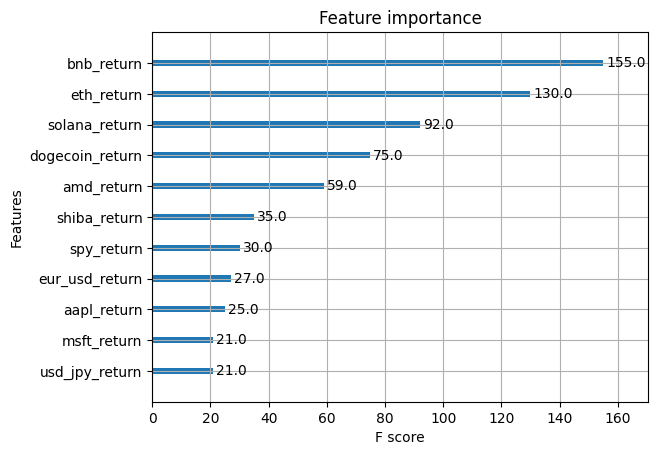

In [ ]:
xgb.plot_importance(xg_reg)

<Axes: >

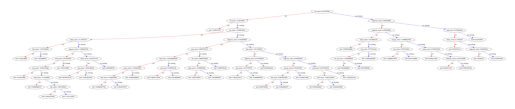

In [ ]:
from xgboost import plot_tree
plot_tree(xg_reg._Booster)

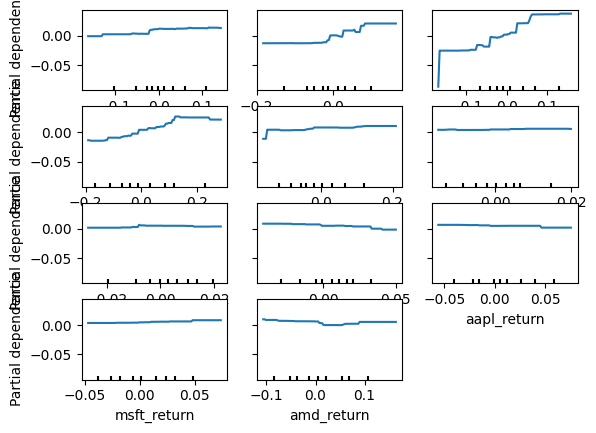

In [ ]:
# from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

features = ['bnb_return','dogecoin_return', 'eth_return', 'solana_return','eur_usd_return','usd_jpy_return']

PartialDependenceDisplay.from_estimator(xg_reg, X_train,
                                                [1, 2,3,4,5,6,7,8,9,10,11])


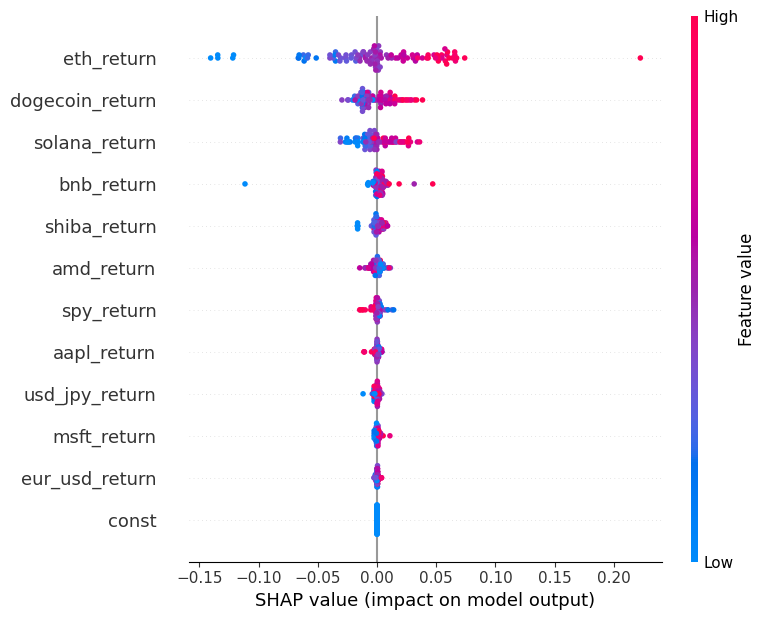

In [ ]:
import shap

explainer = shap.Explainer(xg_reg)
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train)

In [ ]:
import numpy as np

def sensitivity_analysis(model, X, feature, values):
  original_values = X[feature].copy()
  predictions = {}
  for val in values:
    X[feature] = val
    predictions[val] = model.predict(X)

  X[feature] = original_values
  return predictions


In [ ]:
X_test.head()

,const,bnb_return,dogecoin_return,eth_return,solana_return,shiba_return,eur_usd_return,usd_jpy_return,spy_return,aapl_return,msft_return,amd_return
53,1.0,0.038267,0.023271,0.143385,0.396962,0.196078,-0.002427,-0.006209,-0.006575,0.023078,0.004138,-0.013099
72,1.0,0.001751,0.022935,0.042963,0.097622,0.004673,0.003389,-0.009063,0.018809,0.031466,0.007540,-0.072188
33,1.0,-0.007804,-0.030471,0.046053,-0.015710,-0.016129,-0.001900,0.025761,-0.032247,-0.047733,-0.044873,-0.119982
44,1.0,-0.054864,-0.002505,-0.058204,-0.188602,-0.078947,0.016631,-0.009327,-0.006223,0.010621,-0.023836,0.016581
121,1.0,-0.002365,-0.014470,-0.062429,0.017002,-0.085714,0.004853,0.015316,0.018678,-0.001800,0.019869,0.008765


In [ ]:
values_to_test = np.linspace(X_test['eth_return'].min(), X_test['eth_return'].max(),100)
preds = sensitivity_analysis(xg_reg, X_test, 'eth_return', values_to_test)

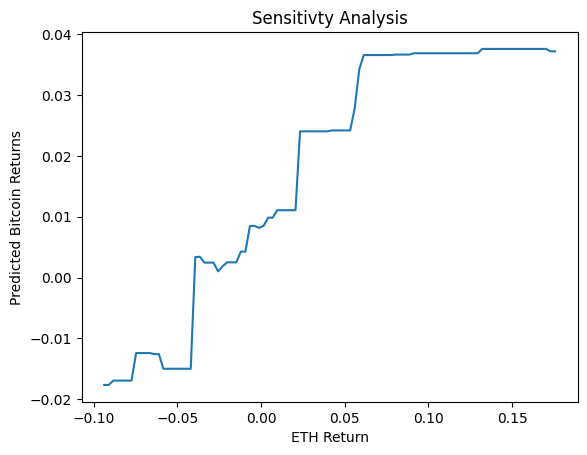

In [ ]:
plt.plot(values_to_test, [np.mean(pred) for pred in preds.values()])
plt.xlabel('ETH Return')
plt.ylabel('Predicted Bitcoin Returns')
plt.title('Sensitivty Analysis')
plt.show()

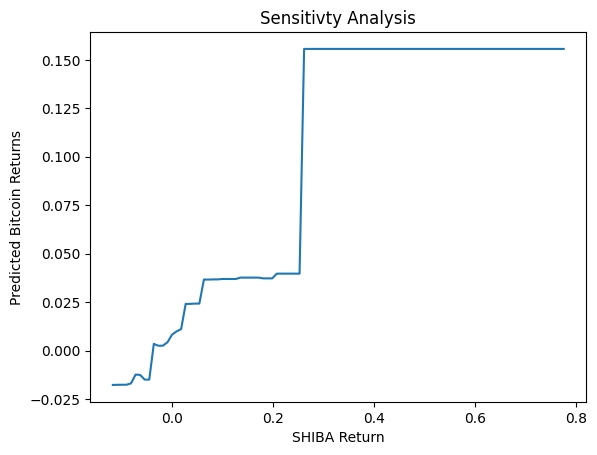

In [ ]:
values_to_test = np.linspace(X_test['shiba_return'].min(), X_test['shiba_return'].max(),100)
preds = sensitivity_analysis(xg_reg, X_test, 'eth_return', values_to_test)

plt.plot(values_to_test, [np.mean(pred) for pred in preds.values()])
plt.xlabel('SHIBA Return')
plt.ylabel('Predicted Bitcoin Returns')
plt.title('Sensitivty Analysis')
plt.show()

In [ ]:
# Factor Analysis

In [ ]:
X2= X.drop(['const'],axis=1)
X2 = X2.dropna(axis=0)
X2

,bnb_return,dogecoin_return,eth_return,solana_return,shiba_return,eur_usd_return,usd_jpy_return,spy_return,aapl_return,msft_return,amd_return
1,-0.218005,-0.222875,-0.227211,-0.233944,-0.279221,-0.012514,-0.001095,-0.057540,-0.061594,-0.045680,-0.132013
2,0.007859,-0.006898,-0.004238,-0.184459,-0.040541,-0.014736,0.011922,0.009064,0.048765,0.041313,-0.114216
3,0.033529,0.041274,0.171370,0.228460,0.042254,0.025902,-0.003424,0.015273,0.012094,-0.007526,0.174458
4,0.003490,-0.018006,-0.018838,-0.140784,0.292793,-0.001769,0.009482,-0.018364,-0.021753,-0.035628,-0.084304
5,-0.002131,-0.041969,-0.048390,-0.065535,-0.020906,-0.004297,-0.010177,-0.014144,-0.007946,-0.024098,0.005743
...,...,...,...,...,...,...,...,...,...,...,...
132,-0.021264,0.070430,-0.065545,0.082459,-0.044944,-0.004612,-0.021973,-0.008288,-0.028309,-0.027087,-0.076461
133,-0.065676,-0.169820,-0.088505,-0.166534,-0.135294,-0.005868,-0.029252,-0.021196,0.008717,-0.039457,-0.053504
134,-0.062132,-0.067569,-0.129408,0.025020,-0.047619,0.011877,-0.010268,0.000169,-0.016465,-0.006047,0.013359
135,0.021183,-0.033994,-0.002467,-0.109465,-0.057143,0.005223,0.010517,0.040001,0.045366,0.030664,0.106427


In [ ]:
X2.describe()

,bnb_return,dogecoin_return,eth_return,solana_return,shiba_return,eur_usd_return,usd_jpy_return,spy_return,aapl_return,msft_return,amd_return
count,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000
mean,0.004350,-0.000155,0.003086,0.012096,0.002176,-0.000096,0.001950,0.001734,0.002761,0.002878,0.003661
std,0.083388,0.120829,0.095420,0.152492,0.153519,0.011333,0.015169,0.024700,0.038210,0.036557,0.074534
min,-0.245257,-0.327804,-0.347452,-0.516686,-0.360000,-0.030547,-0.044874,-0.061416,-0.111468,-0.077247,-0.165354
25%,-0.035002,-0.056162,-0.053311,-0.071734,-0.066929,-0.007124,-0.006644,-0.012747,-0.021019,-0.024098,-0.048398
50%,-0.002071,-0.010975,-0.004823,-0.012868,-0.020906,-0.000827,0.002818,0.003505,0.001476,0.000837,0.003246
75%,0.045375,0.041274,0.054186,0.097622,0.040984,0.005415,0.011922,0.016442,0.026104,0.023783,0.056481
max,0.296477,0.652848,0.254224,0.433305,1.088757,0.045396,0.034637,0.066200,0.087579,0.124060,0.200435


[4.39753521 2.48778147 1.24914604 0.59698483 0.51640958 0.48613605
 0.31503025 0.30736135 0.25217335 0.23629369 0.15514818]


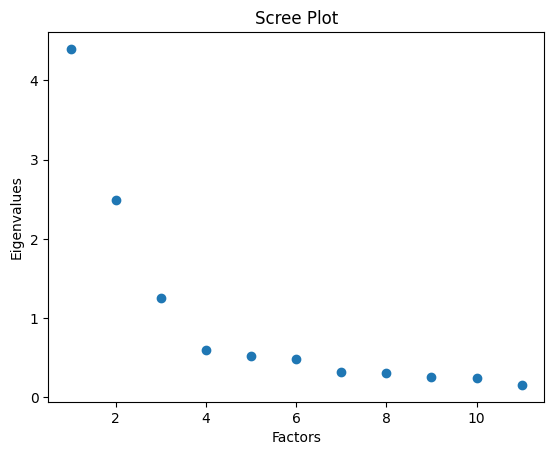

In [ ]:
# Factor Extraction

from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer

scaler = StandardScaler()
scaled_data = scaler.fit_transform(X2)
df_scaled = pd.DataFrame(scaled_data, columns=X2.columns)

fa= FactorAnalyzer(n_factors=10, rotation='varimax')
fa.fit(df_scaled)

ev, v = fa.get_eigenvalues()
print(ev)

import matplotlib.pyplot as plt
plt.scatter(range(1, df_scaled.shape[1]+1), ev)
plt.xlabel('Factors')
plt.ylabel('Eigenvalues')
plt.title('Scree Plot')
plt.show()

In [ ]:
# Factor Rotation

n_factors = 4
fa = FactorAnalyzer(n_factors=n_factors, rotation='varimax')
fa.fit(df_scaled)

loadings = fa.loadings_
print(loadings)

loadings_df = pd.DataFrame(loadings, columns=['Factor 1', 'Factor 2', 'Factor 3', 'Factor 4'], index=X2.columns)
print(loadings_df)

[[ 0.79809274  0.14637312  0.06011757 -0.09376677]
 [ 0.83245432  0.0606696   0.0082202   0.28562083]
 [ 0.83795224  0.2511599   0.05113461 -0.07255682]
 [ 0.79558362  0.0976766   0.06275331 -0.16797833]
 [ 0.72182114  0.01910044  0.11428076  0.32468535]
 [ 0.0543716   0.2466548   0.96537578 -0.02437844]
 [-0.05399283 -0.09702322 -0.47986919 -0.02180596]
 [ 0.17945271  0.90165501  0.18554644  0.06393326]
 [ 0.05278431  0.79824247  0.0946984  -0.04680617]
 [ 0.06630902  0.83897667  0.09892032 -0.09944819]
 [ 0.18873557  0.6235995   0.18931005  0.10308684]]
                 Factor 1  Factor 2  Factor 3  Factor 4
bnb_return       0.798093  0.146373  0.060118 -0.093767
dogecoin_return  0.832454  0.060670  0.008220  0.285621
eth_return       0.837952  0.251160  0.051135 -0.072557
solana_return    0.795584  0.097677  0.062753 -0.167978
shiba_return     0.721821  0.019100  0.114281  0.324685
eur_usd_return   0.054372  0.246655  0.965376 -0.024378
usd_jpy_return  -0.053993 -0.097023 -0.479869 

In [ ]:
communalities = fa.get_communalities()
communalities_df = pd.DataFrame(communalities, index=X2.columns, columns=['Communalities'])
print(communalities_df)

                 Communalities
bnb_return            0.670783
dogecoin_return       0.778308
eth_return            0.773125
solana_return         0.674649
shiba_return          0.639871
eur_usd_return        0.996340
usd_jpy_return        0.243079
spy_return            0.883700
aapl_return           0.651136
msft_return           0.727954
amd_return            0.470963


In [ ]:
import requests
import pandas as pd
import numpy as np

from skfolio import PerfMeasure, RatioMeasure, RiskMeasure, Population
from skfolio.optimization import (
    MeanRisk,
    ObjectiveFunction,
)
from skfolio.preprocessing import prices_to_returns

# plotting
from plotly.io import show
import seaborn as sns
import matplotlib.pyplot as plt

# settings
plt.style.use("seaborn-v0_8-colorblind")
plt.rcParams["figure.figsize"] = (16, 8)

In [ ]:
model = MeanRisk(
    objective_function=ObjectiveFunction.MINIMIZE_RISK,
    risk_measure=RiskMeasure.VARIANCE,
    portfolio_params=dict(name="Min Variance"),
)
model.fit(X2)
min_variance_pred = model.predict(X2)

In [ ]:
model = MeanRisk(
    objective_function=ObjectiveFunction.MAXIMIZE_RETURN,
    portfolio_params=dict(name="Max Return"),

)
model.fit(X2)
max_return_pred = model.predict(X2)

In [ ]:
model = MeanRisk(
    objective_function=ObjectiveFunction.MAXIMIZE_RATIO,
    risk_measure=RiskMeasure.VARIANCE,
    portfolio_params=dict(name="Max Sharpe"),
)
model.fit(X2)
max_sharpe_pred = model.predict(X2)

In [ ]:
population = Population([min_variance_pred, max_return_pred, max_sharpe_pred])
population.plot_composition()

In [ ]:
population.plot_cumulative_returns()

In [ ]:
model = MeanRisk(
    efficient_frontier_size=50,
)
model.fit(X2)
efficient_frontier = model.predict(X2)


fig = efficient_frontier.plot_measures(
    x=RiskMeasure.ANNUALIZED_VARIANCE,
    y=PerfMeasure.ANNUALIZED_MEAN,
    color_scale=RatioMeasure.ANNUALIZED_SHARPE_RATIO,
    hover_measures=[
        RiskMeasure.MAX_DRAWDOWN,
        RatioMeasure.ANNUALIZED_SORTINO_RATIO,
        RiskMeasure.WORST_REALIZATION],

)
show(fig)


In [ ]:
efficient_frontier.plot_composition()

In [ ]:
!pip install pyarrow
!pip install --upgrade mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 4.7 MB/s eta 0:00:00


In [ ]:
def download_klines(symbol, year, month,t):
    url = f'https://data.binance.vision/data/{t}/monthly/klines/{symbol}/1m/{symbol}-1m-{year}-{month:02}.zip'
    df = pd.read_csv(url, header=None)
    df.columns = 'open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ignore'.split(',')
    df.to_parquet(f"data/klines/{symbol}-1m/{symbol}-1m-{year}-{month:02}.parquet")

In [ ]:
def download_trades(symbol, date,t):
    url = f'https://data.binance.vision/data/{t}/daily/trades/{symbol}/{symbol}-trades-{date.year}-{date.month:02}-{date.day:02}.zip'
    df = pd.read_csv(url, header=None)
    df.columns = 'id,price,qty,base_qty,time,is_buyer_maker,ignore'.split(',')
    df.to_parquet(f"data/trades/daily/{symbol}/{symbol}-{date.year}-{date.month:02}-{date.day:02}.parquet")

In [ ]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd
from pathlib import Path
for symbol in ['BTCUSDT', 'ETHUSDT', 'LINKUSTD']:
    output_dir = Path(f"data/klines/{symbol}-1m/")
    output_dir.mkdir(parents=True, exist_ok=True)
    from_date=datetime(2024, 7, 1)
    while from_date<datetime(2024, 8, 1):
        download_klines(symbol,from_date.year,from_date.month,'spot')
        from_date = from_date + relativedelta(month=1)

KeyboardInterrupt: 

In [ ]:
df = pd.read_parquet('data/klines/BTCUSDT-1m/BTCUSDT-1m-2024-07.parquet')
df.head()

,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ignore
0,1719792000000,62772.01,62809.01,62772.00,62776.01,24.35543,1719792059999,1.529470e+06,1215,14.75592,926611.551755,0
1,1719792060000,62776.00,62786.00,62768.00,62769.72,8.85121,1719792119999,5.556372e+05,837,3.05137,191546.077954,0
2,1719792120000,62769.72,62781.55,62760.78,62760.79,20.12564,1719792179999,1.263276e+06,1175,11.17319,701334.594223,0
3,1719792180000,62760.78,62781.60,62745.65,62745.66,19.23422,1719792239999,1.207179e+06,1039,10.66982,669660.859064,0
4,1719792240000,62745.66,62745.66,62722.07,62722.08,20.52790,1719792299999,1.287725e+06,918,2.03293,127522.601857,0


In [ ]:
df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
df.head()

,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ignore
0,2024-07-01 00:00:00,62772.01,62809.01,62772.00,62776.01,24.35543,2024-07-01 00:00:59.999,1.529470e+06,1215,14.75592,926611.551755,0
1,2024-07-01 00:01:00,62776.00,62786.00,62768.00,62769.72,8.85121,2024-07-01 00:01:59.999,5.556372e+05,837,3.05137,191546.077954,0
2,2024-07-01 00:02:00,62769.72,62781.55,62760.78,62760.79,20.12564,2024-07-01 00:02:59.999,1.263276e+06,1175,11.17319,701334.594223,0
3,2024-07-01 00:03:00,62760.78,62781.60,62745.65,62745.66,19.23422,2024-07-01 00:03:59.999,1.207179e+06,1039,10.66982,669660.859064,0
4,2024-07-01 00:04:00,62745.66,62745.66,62722.07,62722.08,20.52790,2024-07-01 00:04:59.999,1.287725e+06,918,2.03293,127522.601857,0


In [ ]:
df = df[['close_time','close']]
df.head()

,close_time,close
0,2024-07-01 00:00:59.999,62776.01
1,2024-07-01 00:01:59.999,62769.72
2,2024-07-01 00:02:59.999,62760.79
3,2024-07-01 00:03:59.999,62745.66
4,2024-07-01 00:04:59.999,62722.08


In [ ]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

from pathlib import Path
for symbol in ['BTCUSDT', 'ETHUSDT', 'LINKUSTD']:
    from_date=datetime(2021, 1, 1)
    output_dir = Path(f"data/trades/daily/{symbol}")
    output_dir.mkdir(parents=True, exist_ok=True)
    while from_date<datetime(2024, 8, 1):
        download_trades('BTCUSDT',from_date,'spot')
        from_date = from_date + relativedelta(days=1)

In [ ]:
import pandas as pd
import os

directory = 'data/klines/BTCUSDT-1m'

all_files = os.listdir(directory)

parquet_files = [file for file in all_files if file.endswith('.parquet')]

dfs = pd.DataFrame()

for file in parquet_files:
    file_path = os.path.join(directory, file)
    df = pd.read_parquet(file_path)
    df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
    df = df[['close_time','close']]
    df.columns = ['date','close']
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['hour'] = df['date'].dt.hour
    df = df.drop_duplicates(['year','month','day','hour'], keep='last')
    df = df.drop(['year','month','day','hour'], axis=1)
    dfs = pd.concat([df, dfs])

df_btc = dfs
df_btc.columns = ['date','btc']
df_btc

<ipython-input-22-d61496584a65>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['date'].dt.year
<ipython-input-22-d61496584a65>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['date'].dt.month
<ipython-input-22-d61496584a65>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

,date,btc
59,2024-04-01 00:59:59.999,71152.86
119,2024-04-01 01:59:59.999,70819.25
179,2024-04-01 02:59:59.999,70866.98
239,2024-04-01 03:59:59.999,70588.01
299,2024-04-01 04:59:59.999,70429.99
...,...,...
44399,2024-05-31 19:59:59.999,67681.00
44459,2024-05-31 20:59:59.999,67709.04
44519,2024-05-31 21:59:59.999,67564.91
44579,2024-05-31 22:59:59.999,67509.52


In [ ]:
directory = 'data/klines/ETHUSDT-1m'

all_files = os.listdir(directory)

parquet_files = [file for file in all_files if file.endswith('.parquet')]

dfs = pd.DataFrame()

for file in parquet_files:
    file_path = os.path.join(directory, file)
    df = pd.read_parquet(file_path)
    df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
    df = df[['close_time','close']]
    df.columns = ['date','close']
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['hour'] = df['date'].dt.hour
    df = df.drop_duplicates(['year','month','day','hour'], keep='last')
    df = df.drop(['year','month','day','hour'], axis=1)
    dfs = pd.concat([df, dfs])

df_eth = dfs
df_eth.columns = ['date','eth']
df_eth

,date,eth
59,2024-05-01 00:59:59.999,2999.05
119,2024-05-01 01:59:59.999,3002.33
179,2024-05-01 02:59:59.999,2987.81
239,2024-05-01 03:59:59.999,3004.37
299,2024-05-01 04:59:59.999,3006.19
...,...,...
42959,2024-04-30 19:59:59.999,2928.96
43019,2024-04-30 20:59:59.999,2967.01
43079,2024-04-30 21:59:59.999,2987.87
43139,2024-04-30 22:59:59.999,3010.11


In [ ]:
directory = 'data/klines/LINKUSTD-1m'

all_files = os.listdir(directory)

parquet_files = [file for file in all_files if file.endswith('.parquet')]

dfs = pd.DataFrame()

for file in parquet_files:
    file_path = os.path.join(directory, file)
    df = pd.read_parquet(file_path)
    df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
    df = df[['close_time','close']]
    df.columns = ['date','close']
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['hour'] = df['date'].dt.hour
    df = df.drop_duplicates(['year','month','day','hour'], keep='last')
    df = df.drop(['year','month','day','hour'], axis=1)
    dfs = pd.concat([df, dfs])

df_link = dfs
df_link.columns = ['date','link']
df_link

,date,link
59,2024-04-01 00:59:59.999,19.166
119,2024-04-01 01:59:59.999,19.177
179,2024-04-01 02:59:59.999,19.248
239,2024-04-01 03:59:59.999,19.169
299,2024-04-01 04:59:59.999,19.051
...,...,...
42959,2024-06-30 19:59:59.999,14.005
43019,2024-06-30 20:59:59.999,14.036
43079,2024-06-30 21:59:59.999,14.049
43139,2024-06-30 22:59:59.999,14.321


In [ ]:
directory = 'data/klines/AVAXUSDT-1m'

all_files = os.listdir(directory)

parquet_files = [file for file in all_files if file.endswith('.parquet')]

dfs = pd.DataFrame()

for file in parquet_files:
    file_path = os.path.join(directory, file)
    df = pd.read_parquet(file_path)
    df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
    df = df[['close_time','close']]
    df.columns = ['date','close']
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['hour'] = df['date'].dt.hour
    df = df.drop_duplicates(['year','month','day','hour'], keep='last')
    df = df.drop(['year','month','day','hour'], axis=1)
    dfs = pd.concat([df, dfs])

df_avax = dfs
df_avax.columns = ['date','avax']
df_avax

,date,avax
59,2024-05-01 00:59:59.999,32.42
119,2024-05-01 01:59:59.999,32.65
179,2024-05-01 02:59:59.999,32.51
239,2024-05-01 03:59:59.999,32.64
299,2024-05-01 04:59:59.999,32.65
...,...,...
42959,2024-06-30 19:59:59.999,28.52
43019,2024-06-30 20:59:59.999,28.62
43079,2024-06-30 21:59:59.999,28.46
43139,2024-06-30 22:59:59.999,29.41


In [ ]:
# directory = 'data/klines/SHIBUSDT-1m'

# all_files = os.listdir(directory)

# parquet_files = [file for file in all_files if file.endswith('.parquet')]

# dfs = pd.DataFrame()

# for file in parquet_files:
#     file_path = os.path.join(directory, file)
#     df = pd.read_parquet(file_path)
#     df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
#     df = df[['close_time','close']]
#     df.columns = ['date','close']
#     df['year'] = df['date'].dt.year
#     df['month'] = df['date'].dt.month
#     df['day'] = df['date'].dt.day
#     df['hour'] = df['date'].dt.hour
#     df = df.drop_duplicates(['year','month','day','hour'], keep='last')
#     df = df.drop(['year','month','day','hour'], axis=1)
#     dfs = pd.concat([df, dfs])

# df_shib = dfs
# df_shib.columns = ['date','shib']
# df_shib

,date,shib
59,2024-04-01 00:59:59.999,0.000031
119,2024-04-01 01:59:59.999,0.000030
179,2024-04-01 02:59:59.999,0.000030
239,2024-04-01 03:59:59.999,0.000030
299,2024-04-01 04:59:59.999,0.000030
...,...,...
44399,2024-05-31 19:59:59.999,0.000026
44459,2024-05-31 20:59:59.999,0.000026
44519,2024-05-31 21:59:59.999,0.000026
44579,2024-05-31 22:59:59.999,0.000025


In [ ]:
directory = 'data/klines/SOLUSDT-1m'

all_files = os.listdir(directory)

parquet_files = [file for file in all_files if file.endswith('.parquet')]

dfs = pd.DataFrame()

for file in parquet_files:
    file_path = os.path.join(directory, file)
    df = pd.read_parquet(file_path)
    df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
    df = df[['close_time','close']]
    df.columns = ['date','close']
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['hour'] = df['date'].dt.hour
    df = df.drop_duplicates(['year','month','day','hour'], keep='last')
    df = df.drop(['year','month','day','hour'], axis=1)
    dfs = pd.concat([df, dfs])

df_sol = dfs
df_sol.columns = ['date','sol']
df_sol

,date,sol
59,2024-07-01 00:59:59.999,147.83
119,2024-07-01 01:59:59.999,148.26
179,2024-07-01 02:59:59.999,147.42
239,2024-07-01 03:59:59.999,147.61
299,2024-07-01 04:59:59.999,147.45
...,...,...
42959,2024-04-30 19:59:59.999,123.04
43019,2024-04-30 20:59:59.999,124.94
43079,2024-04-30 21:59:59.999,125.68
43139,2024-04-30 22:59:59.999,127.38


In [ ]:
df_total = pd.merge(df_btc, df_eth, on = 'date', how='left')
df_total = pd.merge(df_total, df_link, on = 'date', how='left')
df_total = pd.merge(df_total, df_avax, on = 'date', how='left')
# df_total = pd.merge(df_total, df_shib, on = 'date', how='left')
df_total = pd.merge(df_total, df_sol, on = 'date', how='left')
# df_total.columns = ['date','bitcoin','eth','link','avax','shib','sol']
df_total

,date,btc,eth,link,avax,sol
0,2024-04-01 00:59:59.999,71152.86,3625.41,19.166,53.44,201.99
1,2024-04-01 01:59:59.999,70819.25,3609.79,19.177,53.54,203.10
2,2024-04-01 02:59:59.999,70866.98,3613.01,19.248,53.84,202.67
3,2024-04-01 03:59:59.999,70588.01,3610.42,19.169,53.80,202.58
4,2024-04-01 04:59:59.999,70429.99,3600.41,19.051,53.37,201.08
...,...,...,...,...,...,...
2923,2024-05-31 19:59:59.999,67681.00,3785.45,18.228,36.14,166.33
2924,2024-05-31 20:59:59.999,67709.04,3794.56,18.552,36.31,166.60
2925,2024-05-31 21:59:59.999,67564.91,3785.51,18.376,36.34,166.51
2926,2024-05-31 22:59:59.999,67509.52,3770.38,18.425,36.16,166.15


In [ ]:
df_total = df_total.sort_values(by='date')
df_total


,date,btc,eth,link,avax,sol
0,2024-04-01 00:59:59.999,71152.86,3625.41,19.166,53.44,201.99
1,2024-04-01 01:59:59.999,70819.25,3609.79,19.177,53.54,203.10
2,2024-04-01 02:59:59.999,70866.98,3613.01,19.248,53.84,202.67
3,2024-04-01 03:59:59.999,70588.01,3610.42,19.169,53.80,202.58
4,2024-04-01 04:59:59.999,70429.99,3600.41,19.051,53.37,201.08
...,...,...,...,...,...,...
2179,2024-07-31 19:59:59.999,65256.83,3266.19,12.920,26.02,176.59
2180,2024-07-31 20:59:59.999,64595.81,3222.45,12.800,25.59,173.50
2181,2024-07-31 21:59:59.999,64978.00,3238.89,12.870,25.81,173.87
2182,2024-07-31 22:59:59.999,64980.01,3243.34,12.870,25.88,173.33


In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np

maxlag=3
test = 'ssr_chi2test'

df_causality = df_total[['btc','eth','link','avax','sol']]

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):

    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df_causality, variables = df_causality.columns)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print resul

,btc_x,eth_x,link_x,avax_x,sol_x
btc_y,1.0000,0.2954,0.2528,0.5881,0.0870
eth_y,0.3795,1.0000,0.0770,0.2357,0.4397
link_y,0.2851,0.2530,1.0000,0.1049,0.2521
avax_y,0.0482,0.0154,0.1754,1.0000,0.3154
sol_y,0.0255,0.0067,0.0688,0.0999,1.0000


In [ ]:
maxlag=3
test = 'ssr_chi2test'

df_causality = df_total[['btc','eth','link','avax','sol']]
df_causality_diff = df_causality.pct_change().dropna()

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):

    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df_causality_diff, variables = df_causality_diff.columns)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print resul

,btc_x,eth_x,link_x,avax_x,sol_x
btc_y,1.0000,0.2724,0.6374,0.2569,0.0303
eth_y,0.1574,1.0000,0.0368,0.1023,0.0782
link_y,0.1063,0.3655,1.0000,0.0423,0.0416
avax_y,0.0362,0.0281,0.0265,1.0000,0.1471
sol_y,0.0006,0.0095,0.0255,0.1002,1.0000


In [ ]:
df_causality_diff_2 = df_causality_diff[['btc','eth','link','avax']]
df_causality_diff_2['btc_shift3'] = df_causality_diff_2['btc'].shift(3)
df_causality_diff_2['eth_shift3'] = df_causality_diff_2['eth'].shift(3)
df_causality_diff_2['link_shift3'] = df_causality_diff_2['link'].shift(3)

df_causality_diff_2 = df_causality_diff_2.dropna()
df_causality_diff_2

,btc,eth,link,avax,btc_shift3,eth_shift3,link_shift3
4,-0.002239,-0.002773,-0.006156,-0.007993,-0.004689,-0.004308,0.000574
5,-0.017926,-0.025111,-0.036166,-0.039535,0.000674,0.000892,0.003702
6,0.006470,0.009202,0.013996,0.016192,-0.003937,-0.000717,-0.004104
7,-0.000288,0.001293,0.001182,0.002304,-0.002239,-0.002773,-0.006156
8,-0.002964,-0.003575,-0.007457,-0.009385,-0.017926,-0.025111,-0.036166
...,...,...,...,...,...,...,...
2179,-0.019107,-0.015553,-0.015244,-0.028016,-0.000271,-0.003613,-0.005356
2180,-0.010130,-0.013392,-0.009288,-0.016526,0.004882,0.007589,0.004615
2181,0.005917,0.005102,0.005469,0.008597,-0.002369,0.000721,0.004594
2182,0.000031,0.001374,0.000000,0.002712,-0.019107,-0.015553,-0.015244


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = df_causality_diff_2[['btc_shift3','eth_shift3','link_shift3']]
y = df_causality_diff_2['avax']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xg_reg = xgb.XGBRegressor(objective='reg:squarederror', max_depth=10)

xg_reg.fit(X, y)

# preds = xg_reg.predict(X_test)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
import numpy as np

def sensitivity_analysis(model, X, feature, values):
  original_values = X[feature].copy()
  predictions = {}
  for val in values:
    X[feature] = val
    predictions[val] = model.predict(X)

  X[feature] = original_values
  return predictions

values_to_test = np.linspace(X['btc_shift3'].min(), X['btc_shift3'].max(),100)
preds = sensitivity_analysis(xg_reg, X, 'btc_shift3', values_to_test)



<ipython-input-42-8bb0f3ea9e88>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = val
<ipython-input-42-8bb0f3ea9e88>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = val
<ipython-input-42-8bb0f3ea9e88>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

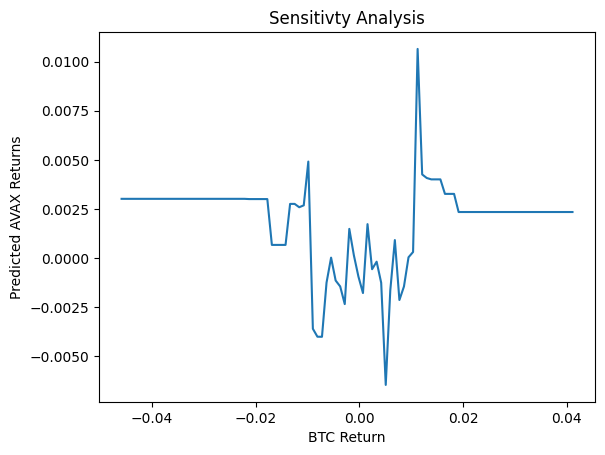

In [ ]:
from matplotlib import pyplot as plt

plt.plot(values_to_test, [np.mean(pred) for pred in preds.values()])
plt.xlabel('BTC Return')
plt.ylabel('Predicted AVAX Returns')
plt.title('Sensitivty Analysis')
plt.show()

<ipython-input-42-8bb0f3ea9e88>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = val
<ipython-input-42-8bb0f3ea9e88>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = val
<ipython-input-42-8bb0f3ea9e88>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

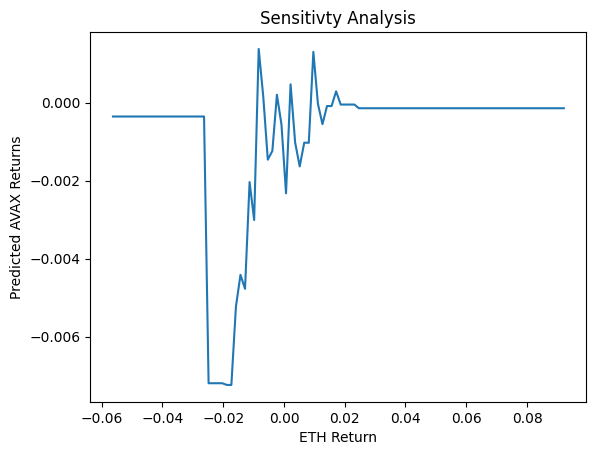

In [ ]:
values_to_test = np.linspace(X['eth_shift3'].min(), X['eth_shift3'].max(),100)
preds = sensitivity_analysis(xg_reg, X, 'eth_shift3', values_to_test)

plt.plot(values_to_test, [np.mean(pred) for pred in preds.values()])
plt.xlabel('ETH Return')
plt.ylabel('Predicted AVAX Returns')
plt.title('Sensitivty Analysis')
plt.show()

<ipython-input-42-8bb0f3ea9e88>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = val
<ipython-input-42-8bb0f3ea9e88>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = val
<ipython-input-42-8bb0f3ea9e88>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

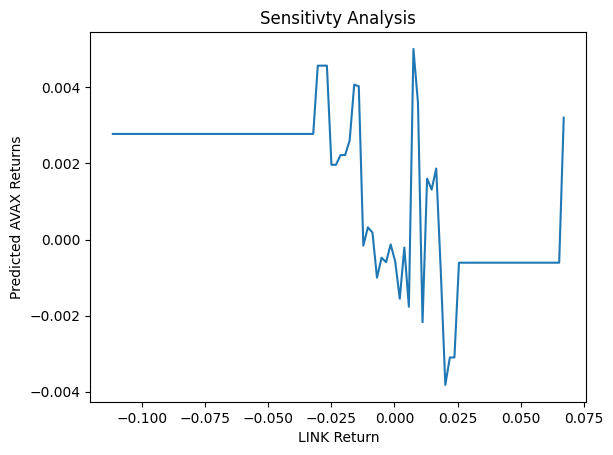

In [ ]:
values_to_test = np.linspace(X['link_shift3'].min(), X['link_shift3'].max(),100)
preds = sensitivity_analysis(xg_reg, X, 'link_shift3', values_to_test)

plt.plot(values_to_test, [np.mean(pred) for pred in preds.values()])
plt.xlabel('LINK Return')
plt.ylabel('Predicted AVAX Returns')
plt.title('Sensitivty Analysis')
plt.show()

In [5]:
import pandas as pd
import os

directory = 'data/klines/BTCUSDT-1m'

all_files = os.listdir(directory)

parquet_files = [file for file in all_files if file.endswith('.parquet')]

dfs = pd.DataFrame()

for file in parquet_files:
    file_path = os.path.join(directory, file)
    df = pd.read_parquet(file_path)
    df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
    df = df[['close_time','close']]
    df.columns = ['date','close']
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['hour'] = df['date'].dt.hour
    df = df.drop_duplicates(['year','month','day','hour'], keep='last')
    df = df.drop(['year','month','day','hour'], axis=1)
    dfs = pd.concat([df, dfs])

df_btc = dfs
df_btc.columns = ['date','btc']
df_btc

,date,btc
59,2024-05-01 00:59:59.999,60240.57
119,2024-05-01 01:59:59.999,60133.78
179,2024-05-01 02:59:59.999,59927.99
239,2024-05-01 03:59:59.999,60246.03
299,2024-05-01 04:59:59.999,60283.99
...,...,...
44399,2024-07-31 19:59:59.999,65256.83
44459,2024-07-31 20:59:59.999,64595.81
44519,2024-07-31 21:59:59.999,64978.00
44579,2024-07-31 22:59:59.999,64980.01


In [6]:
df_btc['btc_return'] = df_btc['btc'].pct_change()
df_btc = df_btc.dropna()
df_btc

,date,btc,btc_return
119,2024-05-01 01:59:59.999,60133.78,-0.001773
179,2024-05-01 02:59:59.999,59927.99,-0.003422
239,2024-05-01 03:59:59.999,60246.03,0.005307
299,2024-05-01 04:59:59.999,60283.99,0.000630
359,2024-05-01 05:59:59.999,60050.00,-0.003881
...,...,...,...
44399,2024-07-31 19:59:59.999,65256.83,-0.019107
44459,2024-07-31 20:59:59.999,64595.81,-0.010130
44519,2024-07-31 21:59:59.999,64978.00,0.005917
44579,2024-07-31 22:59:59.999,64980.01,0.000031


In [42]:
df_btc_2 = df_btc.loc[df_btc['date'] < '2024-07-31']
df_btc_2

,date,btc,btc_return
119,2024-05-01 01:59:59.999,60133.78,-0.001773
179,2024-05-01 02:59:59.999,59927.99,-0.003422
239,2024-05-01 03:59:59.999,60246.03,0.005307
299,2024-05-01 04:59:59.999,60283.99,0.000630
359,2024-05-01 05:59:59.999,60050.00,-0.003881
...,...,...,...
42959,2024-07-30 19:59:59.999,65931.02,0.001626
43019,2024-07-30 20:59:59.999,66186.01,0.003868
43079,2024-07-30 21:59:59.999,66304.00,0.001783
43139,2024-07-30 22:59:59.999,66222.00,-0.001237


In [12]:
pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 22.0 MB/s eta 0:00:00


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
import scipy.stats as stats

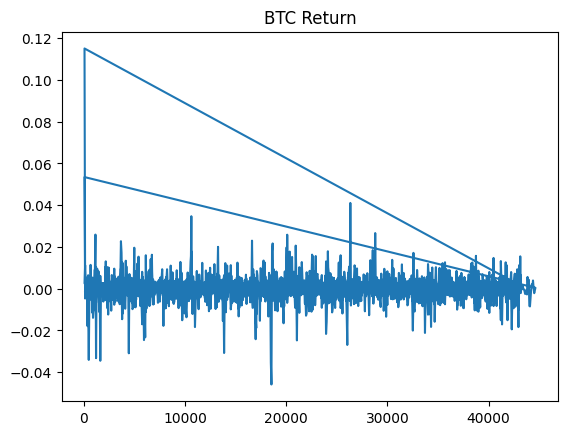

In [43]:
plt.plot(df_btc_2['btc_return'])
plt.title('BTC Return')
plt.show()

In [44]:
result = adfuller(df_btc_2['btc_return'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] > result[4]['5%']:
    print('The series is non-stationary')
else:
    print('The series is stationary')

ADF Statistic: -24.017673
p-value: 0.000000
	1%: -3.433
	5%: -2.863
	10%: -2.567
The series is stationary


In [59]:
model = arch_model(df_btc_2['btc_return'], vol='GARCH', p=1, q=1)
model_fitted = model.fit(update_freq=5)

forecast = model_fitted.forecast(horizon=24)
volatility_forecast = np.sqrt(forecast.variance.values[-1])

Inequality constraints incompatible    (Exit mode 4)
            Current function value: -11098.340435708278
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.291e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [61]:
forecast.variance

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10,...,h.15,h.16,h.17,h.18,h.19,h.20,h.21,h.22,h.23,h.24
43199,0.000015,0.000015,0.000016,0.000016,0.000017,0.000017,0.000017,0.000017,0.000018,0.000018,...,0.00002,0.00002,0.00002,0.00002,0.000021,0.000021,0.000021,0.000021,0.000022,0.000022


In [60]:
volatility_forecast

array([0.00388982, 0.00393526, 0.0039793 , 0.00402198, 0.00406338,
       0.00410354, 0.00414252, 0.00418037, 0.00421714, 0.00425286,
       0.00428758, 0.00432133, 0.00435415, 0.00438608, 0.00441715,
       0.00444738, 0.00447681, 0.00450547, 0.00453337, 0.00456056,
       0.00458704, 0.00461285, 0.004638  , 0.00466251])

In [75]:
standard_error_volatility = np.sqrt(np.mean(df_btc_2['btc_return']**2))


In [76]:
standard_error_volatility

0.005737081848582249

In [77]:
z_score = stats.norm.ppf((1 + confidence_level) / 2)
z_score

1.959963984540054

In [78]:
lower_bound = volatility_forecast - z_score * standard_error_volatility
upper_bound = volatility_forecast + z_score * standard_error_volatility

In [79]:
lower_bound

array([-0.00735466, -0.00730921, -0.00726518, -0.00722249, -0.0071811 ,
       -0.00714093, -0.00710195, -0.0070641 , -0.00702734, -0.00699162,
       -0.0069569 , -0.00692315, -0.00689032, -0.00685839, -0.00682733,
       -0.00679709, -0.00676766, -0.00673901, -0.0067111 , -0.00668392,
       -0.00665743, -0.00663163, -0.00660648, -0.00658196])

In [80]:
upper_bound

array([0.01513429, 0.01517974, 0.01522377, 0.01526645, 0.01530785,
       0.01534802, 0.015387  , 0.01542485, 0.01546161, 0.01549733,
       0.01553205, 0.0155658 , 0.01559862, 0.01563055, 0.01566162,
       0.01569185, 0.01572128, 0.01574994, 0.01577785, 0.01580503,
       0.01583152, 0.01585732, 0.01588247, 0.01590699])

In [81]:
df_btc_test = df_btc.loc[df_btc.date>='2024-07-31']
df_btc_test['lower_bound'] = lower_bound
df_btc_test['upper_bound'] = upper_bound
df_btc_test

<ipython-input-81-4451dace1c82>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc_test['lower_bound'] = lower_bound
<ipython-input-81-4451dace1c82>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc_test['upper_bound'] = upper_bound


,date,btc,btc_return,lower_bound,upper_bound
43259,2024-07-31 00:59:59.999,66344.00,0.002357,-0.007355,0.015134
43319,2024-07-31 01:59:59.999,66296.00,-0.000724,-0.007309,0.015180
43379,2024-07-31 02:59:59.999,66122.16,-0.002622,-0.007265,0.015224
43439,2024-07-31 03:59:59.999,66058.00,-0.000970,-0.007222,0.015266
43499,2024-07-31 04:59:59.999,65804.00,-0.003845,-0.007181,0.015308
43559,2024-07-31 05:59:59.999,66175.52,0.005646,-0.007141,0.015348
43619,2024-07-31 06:59:59.999,66459.99,0.004299,-0.007102,0.015387
43679,2024-07-31 07:59:59.999,66224.00,-0.003551,-0.007064,0.015425
43739,2024-07-31 08:59:59.999,66312.01,0.001329,-0.007027,0.015462
43799,2024-07-31 09:59:59.999,66262.00,-0.000754,-0.006992,0.015497


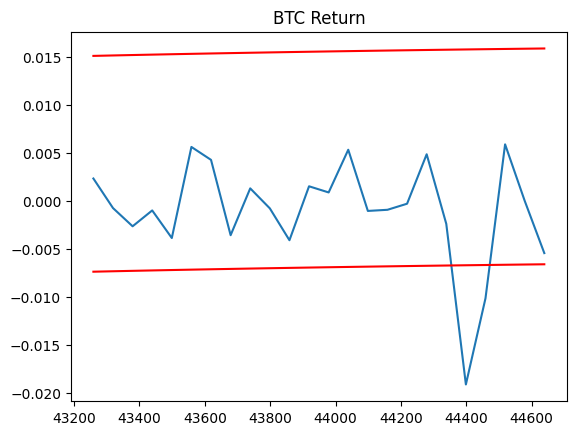

In [82]:
plt.plot(df_btc_test['btc_return'])
plt.title('BTC Return')
plt.plot(df_btc_test['lower_bound'], color='red')
plt.plot(df_btc_test['upper_bound'], color='red')
plt.show()